In [209]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor

In [2]:
area_pre_feature_selection = pd.read_csv('../../data/pre_training/area_pre_feature_selection.csv')
district_pre_feature_selection = pd.read_csv('../../data/pre_training/district_pre_feature_selection.csv')

In [3]:
area_features = area_pre_feature_selection.drop('area_crimes_this_hour', axis=1)
district_features = district_pre_feature_selection.drop('district_crimes_this_hour', axis=1)

area_target = area_pre_feature_selection[['year', 'area_crimes_this_hour']]
district_target = district_pre_feature_selection[['year', 'district_crimes_this_hour']]

In [4]:
# break the area dataset into testing and training datasets
area_feature_training_data = area_features[area_features['year'] < 2020].reset_index(drop=True)
area_feature_testing_data = area_features[area_features['year'] == 2020].reset_index(drop=True)

area_target_training_data = area_target[area_target['year'] < 2020].reset_index(drop=True)
area_target_testing_data = area_target[area_target['year'] == 2020].reset_index(drop=True)

In [5]:
# break the district dataset into testing and training datasets
district_feature_training_data = district_features[district_features['year'] < 2020].reset_index(drop=True)
district_feature_testing_data = district_features[district_features['year'] == 2020].reset_index(drop=True)

district_target_training_data = district_target[district_target['year'] < 2020].reset_index(drop=True)
district_target_testing_data = district_target[district_target['year'] == 2020].reset_index(drop=True)

In [6]:
area_target_training_data = area_target_training_data.drop('year', axis=1)
area_target_testing_data = area_target_testing_data.drop('year', axis=1)
district_target_training_data = district_target_training_data.drop('year', axis=1)
district_target_testing_data = district_target_testing_data.drop('year', axis=1)

In [7]:
xgb_area_feature_training_data = area_feature_training_data.drop('date_hour', axis=1)
xgb_area_feature_testing_data = area_feature_testing_data.drop('date_hour', axis=1)

xgb_district_feature_training_data = district_feature_training_data.drop('date_hour', axis=1)
xgb_district_feature_testing_data = district_feature_testing_data.drop('date_hour', axis=1)

In [8]:
def patch_datatypes(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype(np.float32)

    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype(np.int32)    

    cats = df.select_dtypes(exclude=np.number).columns.tolist()

    for col in cats:
        df[col] = df[col].astype('category')
      
    return df

In [9]:
xgb_area_feature_training_data = patch_datatypes(xgb_area_feature_training_data)

In [10]:
xgb_area_feature_testing_data = patch_datatypes(xgb_area_feature_testing_data)

In [11]:
xgb_district_feature_training_data = patch_datatypes(xgb_district_feature_training_data)

In [12]:
xgb_district_feature_testing_data = patch_datatypes(xgb_district_feature_testing_data)

In [13]:
area_dtrain_reg = xgb.DMatrix(xgb_area_feature_training_data, area_target_training_data, enable_categorical=True)
area_dtest_reg = xgb.DMatrix(xgb_area_feature_testing_data, area_target_testing_data, enable_categorical=True)

In [14]:
district_dtrain_reg = xgb.DMatrix(xgb_district_feature_training_data, district_target_training_data, enable_categorical=True)
district_dtest_reg = xgb.DMatrix(xgb_district_feature_testing_data, district_target_testing_data, enable_categorical=True)

In [15]:
class Evaluator:
    def __init__(self, model, testing):
        self.model = model
        self.test_features = testing
        self.sample_size = len(testing.get_label())
        self.independent_vars = len(testing.feature_names)
        self.predictions = None
        self.residuals = None

    def gather_predictions(self):
        self.predictions = self.model.predict(self.test_features)
        self.residuals = self.test_features.get_label() - self.predictions
    
    def mae(self):
        if self.residuals is None:
            return "Predictions need to be gathered first"
        return np.mean(np.abs(self.residuals))
    
    def mse(self):
        if self.residuals is None:
            return "Predictions need to be gathered first"
        return np.mean(self.residuals ** 2)
    
    def rmse(self):
        if self.residuals is None:
            return "Predictions need to be gathered first"
        return np.sqrt(self.mse())
    
    def relative_rmse(self):
        if self.residuals is None:
            return "Predictions need to be gathered first"
        return self.rmse() / max(self.test_features.get_label())

    def r_squared(self):
        if self.residuals is None:
            return "Predictions need to be gathered first"
        ss_res = np.sum(self.residuals ** 2)
        ss_tot = np.sum((self.test_features.get_label() - np.mean(self.test_features.get_label())) ** 2)
        return 1 - (ss_res / ss_tot)

    def adjusted_r_squared(self):
        if self.residuals is None:
            return "Predictions need to be gathered first"
        r2 = self.r_squared()
        return 1 - (1 - r2) * ((self.sample_size - 1) / (self.sample_size - self.independent_vars - 1))
    
    def median_absolute_error(self):
        if self.residuals is None:
            return "Predictions need to be gathered first"
        return np.median(np.abs(self.residuals))

    def feature_importances(self):
        # Get feature importance based on different metrics
        importance_weight = self.model.get_score(importance_type='weight')  # number of times a feature is used to split the data
        importance_gain = self.model.get_score(importance_type='gain')  # improvement in accuracy of a feature to the branches it's on
        importance_cover = self.model.get_score(importance_type='cover')  # average number of samples affected by a feature

        # Sort and print feature importance based on weight
        sorted_weight = sorted(importance_weight.items(), key=lambda x: x[1], reverse=True)
        print("Feature importance based on weight (sorted):", sorted_weight)

        # Sort and print feature importance based on gain
        sorted_gain = sorted(importance_gain.items(), key=lambda x: x[1], reverse=True)
        print("Feature importance based on gain (sorted):", sorted_gain)

        # Sort and print feature importance based on cover
        sorted_cover = sorted(importance_cover.items(), key=lambda x: x[1], reverse=True)
        print("Feature importance based on cover (sorted):", sorted_cover)

        return importance_weight, importance_gain, importance_cover

    def plot_residuals(self, title, save_name):
        # Calculate percent differences
        percent_diff = (self.residuals / max(self.test_features.get_label())) * 100
        
        plt.figure(figsize=(10, 5))
        plt.plot(percent_diff, label='Percent Difference', marker='o')
        
        # Calculate the average percent difference and plot it
        avg_percent_diff = np.mean(percent_diff)
        plt.axhline(y=avg_percent_diff, color='r', linestyle='dashed', label='Average Percent Difference')
        
        plt.text(0, avg_percent_diff + 1, f'Avg: {avg_percent_diff:.5f}%', color='r', fontsize=12)

        plt.title(f'Percent Difference between Test Labels and Predicted Values - {title} Model')
        plt.xlabel('Sample Index')
        plt.ylabel('Percent Difference (%)')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'../results/xgboost/{save_name}.png')
        plt.show()

In [254]:
def evaluate(model, test_labels, title=None, save_name=None):
    ev = Evaluator(model, test_labels)
    ev.gather_predictions()
    
    print(f"Mean Absolute Error (MAE): {ev.mae():.4f}")
    print(f"Mean Squared Error (MSE): {ev.mse():.4f}")
    print(f"Root Mean Squared Error (RMSE): {ev.rmse():.4f}")
    print(f"Relative Root Mean Squared Error (Relative RMSE): {ev.relative_rmse():.4f}")
    print(f"R-squared (R²): {ev.r_squared():.4f}")
    print(f"Adjusted R-squared: {ev.adjusted_r_squared():.4f}")
    print(f"Median Absolute Error: {ev.median_absolute_error():.4f}")
    
    importance_weight, importance_gain, importance_cover = ev.feature_importances()

    if title is not None:
        ev.plot_residuals(title, save_name)

    return importance_weight, importance_gain, importance_cover

##### Training the Area XGBoost Model

In [17]:
area_params = {"objective": "reg:squarederror", "device":"gpu", "eta":"0.001"}
area_evals = [(area_dtest_reg, "validation"), (area_dtrain_reg, "train")]

In [18]:
area_model = xgb.train(
   params=area_params,
   dtrain=area_dtrain_reg,
   num_boost_round=10000000,
   evals=area_evals,
   verbose_eval=100,
   early_stopping_rounds=100
)

[0]	validation-rmse:0.00249	train-rmse:0.00298
[100]	validation-rmse:0.00235	train-rmse:0.00281
[200]	validation-rmse:0.00223	train-rmse:0.00266
[300]	validation-rmse:0.00211	train-rmse:0.00253
[400]	validation-rmse:0.00201	train-rmse:0.00240
[500]	validation-rmse:0.00191	train-rmse:0.00229
[600]	validation-rmse:0.00182	train-rmse:0.00218
[700]	validation-rmse:0.00174	train-rmse:0.00208
[800]	validation-rmse:0.00167	train-rmse:0.00199
[900]	validation-rmse:0.00161	train-rmse:0.00191
[1000]	validation-rmse:0.00155	train-rmse:0.00183
[1100]	validation-rmse:0.00150	train-rmse:0.00177
[1200]	validation-rmse:0.00145	train-rmse:0.00170
[1300]	validation-rmse:0.00140	train-rmse:0.00163
[1400]	validation-rmse:0.00135	train-rmse:0.00158
[1500]	validation-rmse:0.00131	train-rmse:0.00152
[1600]	validation-rmse:0.00127	train-rmse:0.00147
[1700]	validation-rmse:0.00124	train-rmse:0.00142
[1800]	validation-rmse:0.00121	train-rmse:0.00138
[1900]	validation-rmse:0.00118	train-rmse:0.00135
[2000]	valid

Mean Absolute Error (MAE): 0.0001
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0008
Relative Root Mean Squared Error (Relative RMSE): 0.0028
R-squared (R²): 0.9080
Adjusted R-squared: 0.9080
Median Absolute Error: 0.0000
Feature importance based on weight (sorted): [('bus_stops_distance_0.1', 529279.0), ('streetlights_oneout_distance_0.3', 472820.0), ('alleylights_distance_0.1', 438498.0), ('streetlights_allout_distance_0.5', 400376.0), ('police_stations_distance_1', 394873.0), ('streetlights_oneout_distance_0.1', 370933.0), ('day', 340887.0), ('bike_stations_distance_0.3', 307438.0), ('streetlights_allout_distance_1', 303044.0), ('streetlights_allout_distance_0.3', 297298.0), ('streetlights_oneout_distance_0.5', 291244.0), ('alleylights_distance_0.3', 287630.0), ('area_crimes_24_hours_prev', 280141.0), ('police_stations_distance_3', 266588.0), ('bike_stations_distance_0.1', 262817.0), ('bus_stops_distance_0.3', 256159.0), ('hour', 249642.0), ('police_stations_dis

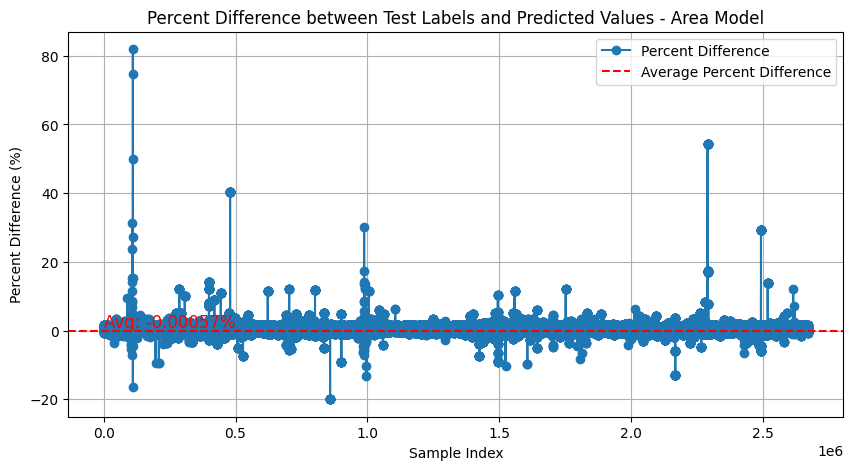

In [19]:
area_importance_weight, area_importance_gain, area_importance_cover = evaluate(area_model, area_dtest_reg, 'Area', 'area_residuals')

##### Training the District XGBoost Model

In [20]:
district_params = {"objective": "reg:squarederror", "device":"gpu", "eta":"0.001"}
district_evals = [(district_dtest_reg, "validation"), (district_dtrain_reg, "train")]

In [21]:
district_model = xgb.train(
   params=district_params,
   dtrain=district_dtrain_reg,
   num_boost_round=10000000,
   evals=district_evals,
   verbose_eval=100,
   early_stopping_rounds=100
)

[0]	validation-rmse:0.00448	train-rmse:0.00531
[100]	validation-rmse:0.00421	train-rmse:0.00501
[200]	validation-rmse:0.00398	train-rmse:0.00474
[300]	validation-rmse:0.00376	train-rmse:0.00450
[400]	validation-rmse:0.00357	train-rmse:0.00427
[500]	validation-rmse:0.00340	train-rmse:0.00407
[600]	validation-rmse:0.00324	train-rmse:0.00388
[700]	validation-rmse:0.00310	train-rmse:0.00371
[800]	validation-rmse:0.00297	train-rmse:0.00355
[900]	validation-rmse:0.00286	train-rmse:0.00340
[1000]	validation-rmse:0.00275	train-rmse:0.00327
[1100]	validation-rmse:0.00267	train-rmse:0.00316
[1200]	validation-rmse:0.00258	train-rmse:0.00305
[1300]	validation-rmse:0.00251	train-rmse:0.00295
[1400]	validation-rmse:0.00244	train-rmse:0.00285
[1500]	validation-rmse:0.00238	train-rmse:0.00277
[1600]	validation-rmse:0.00232	train-rmse:0.00270
[1700]	validation-rmse:0.00227	train-rmse:0.00264
[1800]	validation-rmse:0.00222	train-rmse:0.00257
[1900]	validation-rmse:0.00217	train-rmse:0.00251
[2000]	valid

Mean Absolute Error (MAE): 0.0003
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0016
Relative Root Mean Squared Error (Relative RMSE): 0.0055
R-squared (R²): 0.8709
Adjusted R-squared: 0.8709
Median Absolute Error: 0.0001
Feature importance based on weight (sorted): [('police_stations_distance_1', 532515.0), ('streetlights_allout_distance_0.5', 338536.0), ('streetlights_oneout_distance_0.1', 316107.0), ('streetlights_oneout_distance_0.3', 292254.0), ('alleylights_distance_0.1', 290100.0), ('bus_stops_distance_0.1', 283604.0), ('streetlights_allout_distance_0.3', 266488.0), ('police_stations_distance_3', 223051.0), ('bike_stations_distance_0.1', 218182.0), ('area_crimes_1_hours_prev', 198682.0), ('streetlights_allout_distance_1', 198172.0), ('train_stations_distance_0.3', 172399.0), ('alleylights_distance_0.3', 169152.0), ('bike_stations_distance_0.3', 165767.0), ('area_crimes_3_hours_prev', 162651.0), ('police_stations_distance_5', 162391.0), ('police_stations_dist

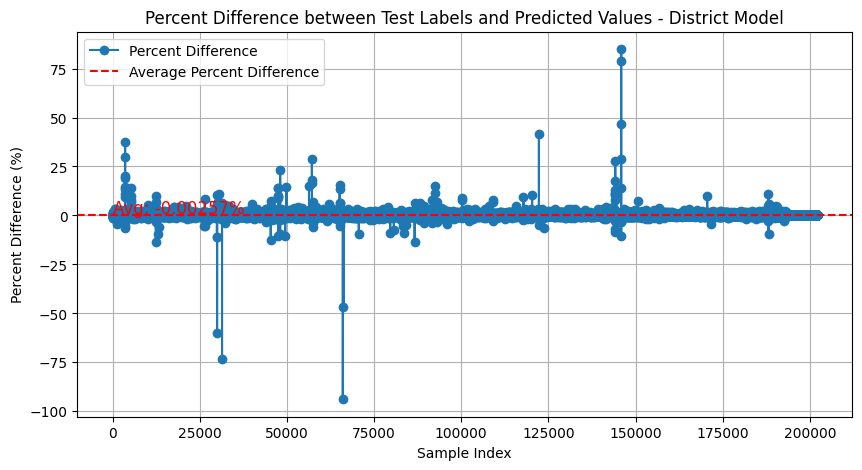

In [22]:
district_importance_weight, district_importance_gain, district_importance_cover = evaluate(district_model, district_dtest_reg, 'District', 'district_residuals')

##### Feature Selection

In [217]:
def normalize_importances(importances):
    total = sum(importances.values())    
    return {key : val / total for key, val in importances.items()}

In [229]:
def extract_features(importances, type, threshold):
    if type == 'cum_sum':
        sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)
        cumulative_sum = 0
        out = []
        for feature, importance in sorted_features:
            cumulative_sum += importance
            out.append(feature)
            if cumulative_sum >= threshold:
                break
        return out
    else:
        return [key for key, val in importances.items() if val >= threshold]

In [257]:
def feature_selection(model, type, training_data, testing_data, thresholds):
    weight_importances = normalize_importances(model.get_score(importance_type='weight'))
    gain_importances = normalize_importances(model.get_score(importance_type='gain'))
    cover_importances = normalize_importances(model.get_score(importance_type='cover'))    
    agg_importances = {feature : np.mean((weight_importances[feature], gain_importances[feature], cover_importances[feature])) for feature in weight_importances.keys()}
    
    for threshold in thresholds:
        target_features = extract_features(agg_importances, type, threshold)
        temp_dtrain = xgb.DMatrix(training_data[0][target_features], training_data[1], enable_categorical=True)
        temp_dtest = xgb.DMatrix(testing_data[0][target_features], testing_data[1], enable_categorical=True)
        temp_model = xgb.train(
            params={"objective": "reg:squarederror", "device":"gpu", "eta":"0.001"},
            dtrain=temp_dtrain,
            num_boost_round=10000000,
            evals=[(temp_dtest, "validation"), (temp_dtrain, "train")],
            verbose_eval=False,
            early_stopping_rounds=100
        )
        print(f'Threshold of {threshold} resulted in the features: {target_features}')
        evaluate(temp_model, temp_dtest)

In [258]:
feature_selection(district_model, 'cum_sum', (xgb_district_feature_training_data, district_target_training_data), (xgb_district_feature_testing_data, district_target_testing_data), np.arange(0.9, 1, 0.02))

Threshold of 0.9 resulted in the features: ['bus_stops_distance_0.1', 'streetlights_allout_distance_0.5', 'alleylights_distance_0.1', 'police_stations_distance_1', 'streetlights_oneout_distance_0.1', 'streetlights_allout_distance_0.3', 'streetlights_oneout_distance_0.3', 'area_crimes_3_hours_prev', 'area_crimes_1_hours_prev', 'bike_rides_within_0.5_and_15_min', 'police_stations_distance_3', 'streetlights_allout_distance_1', 'train_stations_distance_0.3', 'bike_rides_within_0.1_and_5_min', 'bike_stations_distance_0.1', 'alleylights_distance_0.3', 'train_stations_distance_0.5', 'bike_stations_distance_0.3', 'streetlights_oneout_distance_0.5', 'bike_rides_within_0.1_and_15_min', 'alleylights_distance_0.5', 'bike_rides_within_0.3_and_15_min', 'bike_rides_within_0.3_and_5_min', 'police_stations_distance_5', 'bus_stops_distance_0.3', 'bike_stations_distance_0.5', 'bike_rides_within_0.5_and_5_min', 'bike_rides_within_0.3_and_10_min', 'train_stations_distance_1', 'police_stations_distance_0.5'

In [262]:
feature_selection(district_model, 'cum_sum', (xgb_district_feature_training_data, district_target_training_data), (xgb_district_feature_testing_data, district_target_testing_data), np.arange(0.92, 1, 0.02))

Threshold of 0.92 resulted in the features: ['bus_stops_distance_0.1', 'streetlights_allout_distance_0.5', 'alleylights_distance_0.1', 'police_stations_distance_1', 'streetlights_oneout_distance_0.1', 'streetlights_allout_distance_0.3', 'streetlights_oneout_distance_0.3', 'area_crimes_3_hours_prev', 'area_crimes_1_hours_prev', 'bike_rides_within_0.5_and_15_min', 'police_stations_distance_3', 'streetlights_allout_distance_1', 'train_stations_distance_0.3', 'bike_rides_within_0.1_and_5_min', 'bike_stations_distance_0.1', 'alleylights_distance_0.3', 'train_stations_distance_0.5', 'bike_stations_distance_0.3', 'streetlights_oneout_distance_0.5', 'bike_rides_within_0.1_and_15_min', 'alleylights_distance_0.5', 'bike_rides_within_0.3_and_15_min', 'bike_rides_within_0.3_and_5_min', 'police_stations_distance_5', 'bus_stops_distance_0.3', 'bike_stations_distance_0.5', 'bike_rides_within_0.5_and_5_min', 'bike_rides_within_0.3_and_10_min', 'train_stations_distance_1', 'police_stations_distance_0.5

KeyboardInterrupt: 

In [259]:
feature_selection(area_model, 'cum_sum', (xgb_area_feature_training_data, area_target_training_data), (xgb_area_feature_testing_data, area_target_testing_data), np.arange(0.9, 1, 0.02))

Threshold of 0.9 resulted in the features: ['bus_stops_distance_0.1', 'alleylights_distance_0.1', 'streetlights_oneout_distance_0.3', 'streetlights_allout_distance_0.5', 'streetlights_oneout_distance_0.1', 'streetlights_allout_distance_0.3', 'train_stations_distance_0.5', 'police_stations_distance_1', 'area_no_hs_dip', 'bike_stations_distance_0.3', 'area_crimes_24_hours_prev', 'bike_stations_distance_0.1', 'train_stations_distance_0.3', 'bike_rides_within_0.3_and_15_min', 'bike_rides_within_0.5_and_15_min', 'streetlights_allout_distance_1', 'streetlights_allout_distance_0.1', 'streetlights_oneout_distance_0.5', 'alleylights_distance_0.3', 'rides', 'bike_rides_within_0.1_and_15_min', 'bus_stops_distance_0.3', 'police_stations_distance_3', 'district_crimes_1_hours_prev', 'bike_rides_within_0.3_and_5_min', 'bike_stations_distance_0.5', 'police_stations_distance_0.5', 'bike_rides_within_0.5_and_5_min', 'alleylights_distance_0.5', 'streetlights_oneout_distance_1', 'bike_rides_within_0.1_and

In [ ]:
feature_selection(area_model, 'cum_sum', (xgb_area_feature_training_data, area_target_training_data), (xgb_area_feature_testing_data, area_target_testing_data), np.arange(0.88, 1, 0.04))

##### Hyperparameter Tuning

In [165]:
param_grid_district = {
    'n_estimators': [10000],
    'max_depth': np.arange(3, 20, 2),  # Explore deeper trees for potential complex patterns
    'min_child_weight': np.arange(1, 20, 2),  # Allow for more conservative and less conservative splits
    'gamma': np.linspace(0, 1.0, 10),  # Increase gamma range to explore more conservative split criteria
    'subsample': np.linspace(0.3, 1.0, 10),  # Lower the minimum subsample to add more randomness
    'colsample_bytree': np.linspace(0.3, 1.0, 10),  # Lower the minimum colsample_bytree to add more randomness
    'eta': [0.01],
    'objective':['reg:squarederror'],
    'device':['gpu']
}

In [166]:
xgb_model_district = XGBRegressor()

In [167]:
random_search_district = RandomizedSearchCV(
    estimator=xgb_model_district,
    param_distributions=param_grid_district,
    n_iter=200,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=3
)

In [128]:
random_search_district.fit(xgb_district_feature_training_data, district_target_training_data)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3] END colsample_bytree=0.7666666666666666, device=gpu, eta=0.01, gamma=0.2222222222222222, max_depth=19, min_child_weight=11, n_estimators=10000, objective=reg:squarederror, subsample=0.7666666666666666;, score=-0.000 total time=  18.4s
[CV 2/3] END colsample_bytree=0.7666666666666666, device=gpu, eta=0.01, gamma=0.2222222222222222, max_depth=19, min_child_weight=11, n_estimators=10000, objective=reg:squarederror, subsample=0.7666666666666666;, score=-0.000 total time=  17.9s
[CV 3/3] END colsample_bytree=0.7666666666666666, device=gpu, eta=0.01, gamma=0.2222222222222222, max_depth=19, min_child_weight=11, n_estimators=10000, objective=reg:squarederror, subsample=0.7666666666666666;, score=-0.000 total time=  18.1s
[CV 1/3] END colsample_bytree=0.3, device=gpu, eta=0.01, gamma=0.2222222222222222, max_depth=13, min_child_weight=15, n_estimators=10000, objective=reg:squarederror, subsample=0.9222222222222223;, score=-0

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for District Model: {'subsample': np.float64(0.8444444444444446), 'objective': 'reg:squarederror', 'n_estimators': 10000, 'min_child_weight': np.int64(1), 'max_depth': np.int64(19), 'gamma': np.float64(0.0), 'eta': 0.01, 'device': 'gpu', 'colsample_bytree': np.float64(0.6888888888888889)}
Best Score for District Model: -2.804582480618361e-06


In [133]:
print("Best Parameters for District Model:", random_search_district.best_params_)
print("Best Score for District Model:", random_search_district.best_score_)

Best Parameters for District Model: {'subsample': np.float64(0.8444444444444446), 'objective': 'reg:squarederror', 'n_estimators': 10000, 'min_child_weight': np.int64(1), 'max_depth': np.int64(19), 'gamma': np.float64(0.0), 'eta': 0.01, 'device': 'gpu', 'colsample_bytree': np.float64(0.6888888888888889)}
Best Score for District Model: -2.804582480618361e-06


In [203]:
param_grid_district = {
    'n_estimators': [10000],
    'max_depth': [19, 21, 23, 25, None],
    'min_child_weight': [1.0], 
    'gamma': [0.0], 
    'subsample': [0.8, 0.85, 0.9],
    'colsample_bytree': [0.65, 0.7, 0.75], 
    'eta': [0.01],
    'objective': ['reg:squarederror'],
    'device': ['gpu']
}

In [198]:
xgb_model_district = XGBRegressor()

In [201]:
grid_search_district = GridSearchCV(
    estimator=xgb_model_district,
    param_grid=param_grid_district,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3
)

In [204]:
grid_search_district.fit(xgb_district_feature_training_data, district_target_training_data)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


KeyboardInterrupt: 

In [129]:
xgb_model_area = XGBRegressor()

In [130]:
param_grid_area = {
    'n_estimators': [20000],
    'max_depth': np.arange(3, 20, 2),
    'min_child_weight': np.arange(1, 20, 2),
    'gamma': np.linspace(0, 1.0, 10),
    'subsample': np.linspace(0.3, 1.0, 10), 
    'colsample_bytree': np.linspace(0.3, 1.0, 10),
    'eta': [0.01],
    'objective':['reg:squarederror'],
    'device':['gpu']
}

In [131]:
random_search_area = RandomizedSearchCV(
    estimator=xgb_model_area,
    param_distributions=param_grid_area,
    n_iter=200,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=3
)

In [132]:
random_search_area.fit(xgb_area_feature_training_data, area_target_training_data)

print("Best Parameters for Area Model:", random_search_area.best_params_)
print("Best Score for Area Model:", random_search_area.best_score_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3] END colsample_bytree=1.0, device=gpu, eta=0.01, gamma=1.0, max_depth=5, min_child_weight=17, n_estimators=20000, objective=reg:squarederror, subsample=0.6111111111111112;, score=-0.000 total time= 3.1min
[CV 2/3] END colsample_bytree=1.0, device=gpu, eta=0.01, gamma=1.0, max_depth=5, min_child_weight=17, n_estimators=20000, objective=reg:squarederror, subsample=0.6111111111111112;, score=-0.000 total time= 3.1min
[CV 3/3] END colsample_bytree=1.0, device=gpu, eta=0.01, gamma=1.0, max_depth=5, min_child_weight=17, n_estimators=20000, objective=reg:squarederror, subsample=0.6111111111111112;, score=-0.000 total time= 3.1min
[CV 1/3] END colsample_bytree=0.5333333333333333, device=gpu, eta=0.01, gamma=0.8888888888888888, max_depth=17, min_child_weight=13, n_estimators=20000, objective=reg:squarederror, subsample=0.7666666666666666;, score=-0.000 total time= 3.1min
[CV 2/3] END colsample_bytree=0.5333333333333333, devi

KeyboardInterrupt: 